<a href="https://colab.research.google.com/github/Sundaynot/air-quality/blob/main/src/db_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Clonazione della repo se non esiste**

In [1]:
import os
import pandas as pd

# Nome della cartella del repo
repo_name = "air-quality"
repo_url = "https://github.com/sundaynot/air-quality.git"
notebook_path = "src"
csv_path = "../data/Air_Quality.csv"

# 🔁 Clona il repo solo se non esiste già
if not os.path.exists(repo_name):
    print("📥 Clonazione del repository...")
    !git clone {repo_url}
else:
    print("✅ Repository già presente.")

📥 Clonazione del repository...
Cloning into 'air-quality'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 55 (delta 20), reused 10 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 984.06 KiB | 6.11 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
# Mostra tutti i file nella cartella "data"
print(os.listdir("/content/air-quality/data"))
#mostra dove mi trovo
print(os.getcwd())


['Air_Quality.csv']
/content


Visualizzo le prime 5 righe del Database


In [3]:
d = pd.read_csv('/content/air-quality/data/Air_Quality.csv')
d.head()


,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,2023-01-01 00:00:00+00:00,Brasilia,292.0,30.15,1.10,23.0,11.1,15.8,21.158330
1,2023-01-01 01:00:00+00:00,Brasilia,291.0,28.95,1.15,24.0,12.4,17.7,20.825000
2,2023-01-01 02:00:00+00:00,Brasilia,289.0,27.25,1.25,25.0,13.0,18.5,20.474998
3,2023-01-01 03:00:00+00:00,Brasilia,275.0,23.70,1.30,28.0,9.2,13.1,20.074999
4,2023-01-01 04:00:00+00:00,Brasilia,246.0,19.35,1.25,32.0,6.8,9.7,19.324999


In [4]:
d.columns

Index(['Date', 'City', 'CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI'], dtype='object')

In [5]:
d.shape  #restituisce il numero di righe e colonne del database

(52560, 9)

In [6]:
d.describe()  #alcune statistiche sul database

,CO,NO2,SO2,O3,PM2.5,PM10,AQI
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,273.372565,28.930514,12.051645,55.304433,18.621792,35.505850,41.941352
std,171.578815,25.473936,14.684127,36.939938,15.897499,41.866614,24.989747
min,48.000000,0.000000,0.000000,0.000000,0.000000,0.100000,8.000000
25%,160.000000,11.100000,2.500000,29.000000,7.100000,11.000000,22.638333
50%,224.000000,22.100000,5.800000,51.000000,13.400000,20.800000,32.400000
75%,335.000000,38.700000,17.300000,74.000000,24.900000,41.700000,61.013332
max,2145.000000,251.900000,200.800000,425.000000,143.400000,550.000000,188.319980


In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AirQualityAnalysis").getOrCreate()

In [8]:
# Caricamento CSV (adatta il path al tuo caso)
print(os.getcwd())
df = spark.read.csv("/content/air-quality/data/Air_Quality.csv", header=True, inferSchema=True, sep=",")

# Visualizza schema
df.printSchema()

/content
root
 |-- Date: timestamp (nullable = true)
 |-- City: string (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM2.5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- AQI: double (nullable = true)



In [9]:
def clean_column_names(df, default=True):
    """
    Rinomina le colonne del DataFrame rimuovendo caratteri problematici
    come '.' o spazi, sostituendoli con '_', per evitare errori in PySpark.

    Args:
        df: Spark DataFrame
        verbose: Se True, stampa la mappatura vecchio→nuovo nome

    Returns:
        DataFrame con colonne rinominate
    """
    for old_name in df.columns:
        new_name = old_name.replace(".", "_")
        if old_name != new_name:
            if default:
                print(f"Rename: '{old_name}' → '{new_name}'")
            df = df.withColumnRenamed(old_name, new_name)
    return df


In [10]:
df = clean_column_names(df)

Rename: 'PM2.5' → 'PM2_5'


In [11]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- City: string (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- AQI: double (nullable = true)



In [12]:
from pyspark.sql.functions import col,sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+----+----+---+---+---+---+-----+----+---+
|Date|City| CO|NO2|SO2| O3|PM2_5|PM10|AQI|
+----+----+---+---+---+---+-----+----+---+
|   0|   0|  0|  0|  0|  0|    0|   0|  0|
+----+----+---+---+---+---+-----+----+---+



+--------+--------+
|City    |total_CO|
+--------+--------+
|Dubai   |4081205 |
|New York|2837221 |
|Cairo   |2503391 |
|Brasilia|1976571 |
|London  |1767469 |
|Sydney  |1202605 |
+--------+--------+



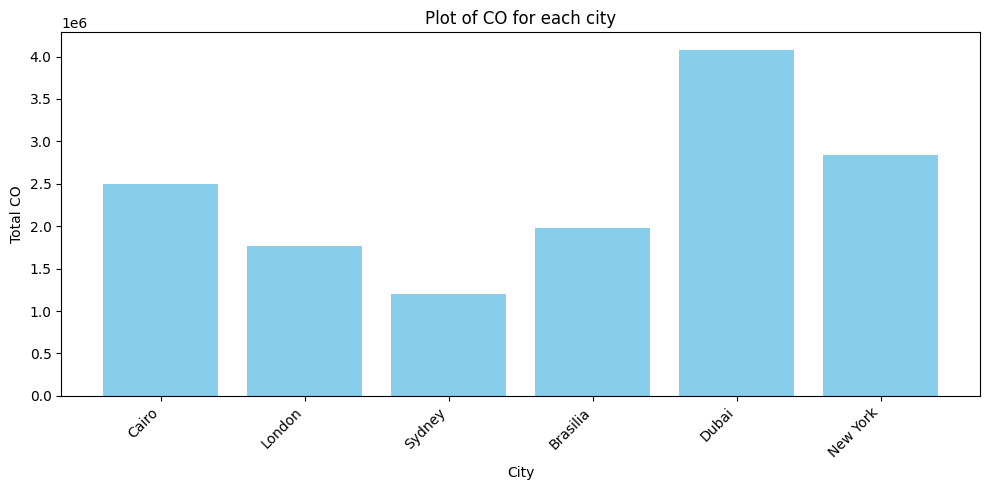

+--------+---------+
|City    |total_NO2|
+--------+---------+
|Dubai   |501839   |
|New York|293315   |
|Cairo   |270333   |
|Sydney  |165202   |
|London  |163439   |
|Brasilia|102843   |
+--------+---------+



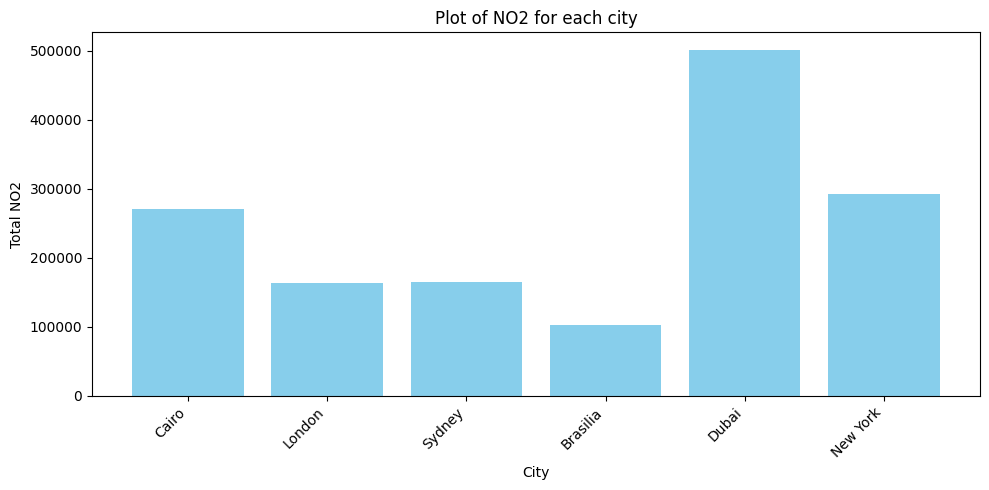

+--------+---------+
|City    |total_SO2|
+--------+---------+
|Cairo   |288248   |
|Dubai   |179048   |
|Sydney  |58722    |
|New York|50640    |
|London  |22142    |
|Brasilia|10528    |
+--------+---------+



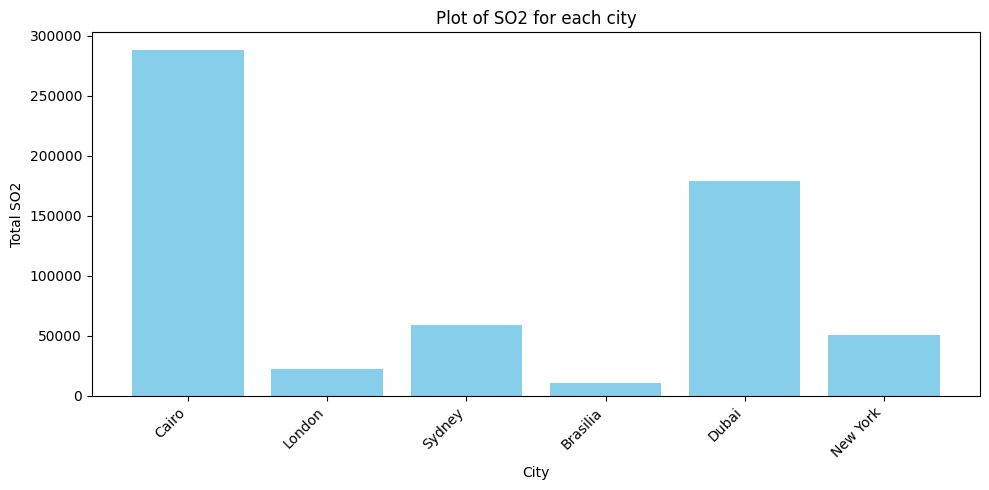

+--------+--------+
|City    |total_O3|
+--------+--------+
|Dubai   |692537  |
|Cairo   |545996  |
|Brasilia|490305  |
|London  |428111  |
|New York|418650  |
|Sydney  |331202  |
+--------+--------+



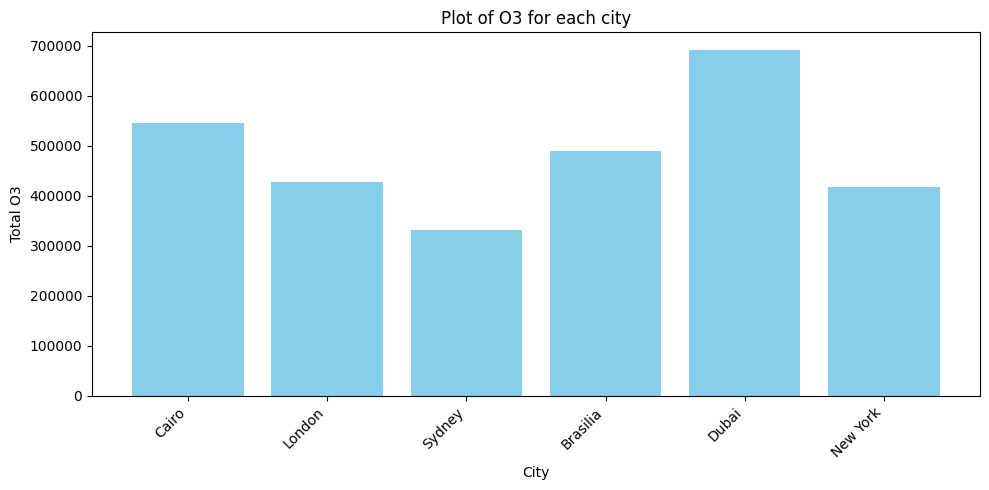

+--------+-----------+
|City    |total_PM2_5|
+--------+-----------+
|Dubai   |352954     |
|Cairo   |231671     |
|New York|139341     |
|Sydney  |98946      |
|London  |73417      |
|Brasilia|58679      |
+--------+-----------+



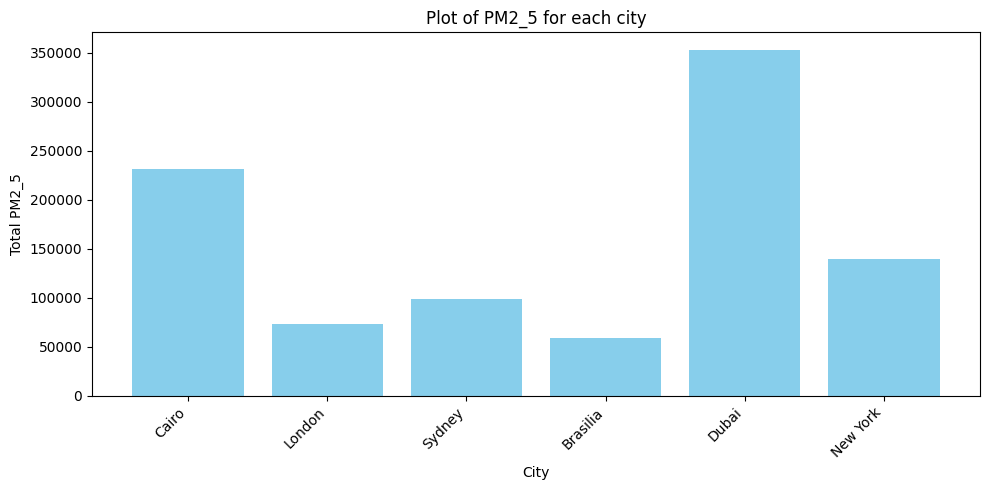

+--------+----------+
|City    |total_PM10|
+--------+----------+
|Dubai   |867515    |
|Cairo   |408997    |
|New York|204571    |
|Sydney  |164176    |
|London  |111374    |
|Brasilia|85954     |
+--------+----------+



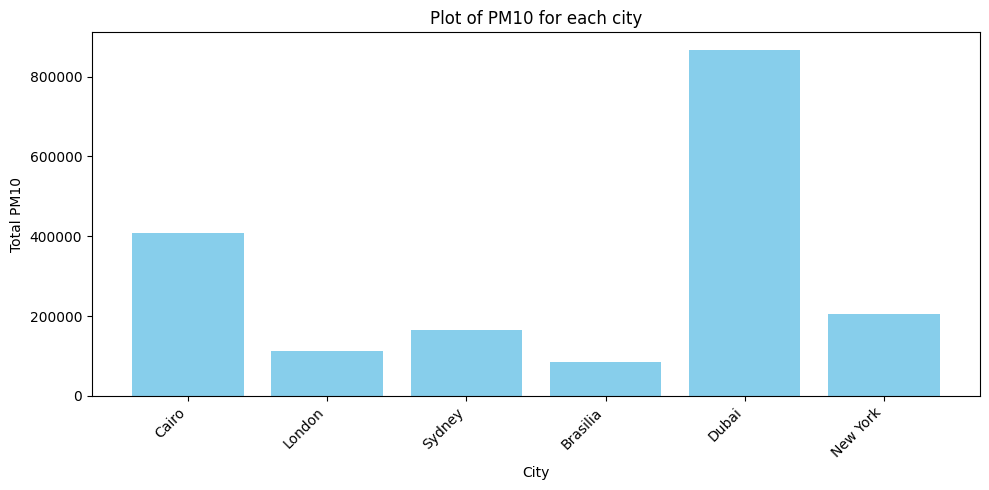

In [24]:
import matplotlib.pyplot as plt

# Colonne da sommare (puoi adattare)
columns_to_sum = ['CO', 'NO2', 'SO2', 'O3', 'PM2_5', 'PM10']


for el in columns_to_sum:
    city_pollution = df.groupBy("City").agg(sum(col(el)).alias(f"total_{el}"))  # Raggruppamento e somma
    city_pollution.orderBy(f"total_{el}", ascending=False).show(truncate=False) # Visualizza le città più inquinate in base al totale
    city_pollution_pd = city_pollution.toPandas()
     # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(city_pollution_pd['City'], city_pollution_pd[f'total_{el}'], color='skyblue')
    plt.title(f'Plot of {el} for each city')
    plt.xlabel('City')
    plt.ylabel(f'Total {el}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


+--------+------------------+------------------+------------------+-----------------+------------------+------------------+
|City    |avg_CO            |avg_NO2           |avg_SO2           |avg_O3           |avg_PM2_5         |avg_PM10          |
+--------+------------------+------------------+------------------+-----------------+------------------+------------------+
|Dubai   |465.8909817351598 |57.28755707762557 |20.439269406392693|79.05673515981735|40.291552511415524|99.03139269406392 |
|New York|323.88367579908675|33.483447488584474|5.780821917808219 |47.79109589041096|15.906506849315068|23.352853881278538|
|Cairo   |285.77522831050226|30.859931506849314|32.905022831050225|62.3283105022831 |26.446461187214613|46.68915525114155 |
|Brasilia|225.6359589041096 |11.740068493150686|1.2018264840182649|55.9708904109589 |6.698515981735159 |9.812100456621005 |
|London  |201.76586757990867|18.6574200913242  |2.5276255707762556|48.87111872146119|8.380936073059361 |12.713926940639269|
|Sydney 

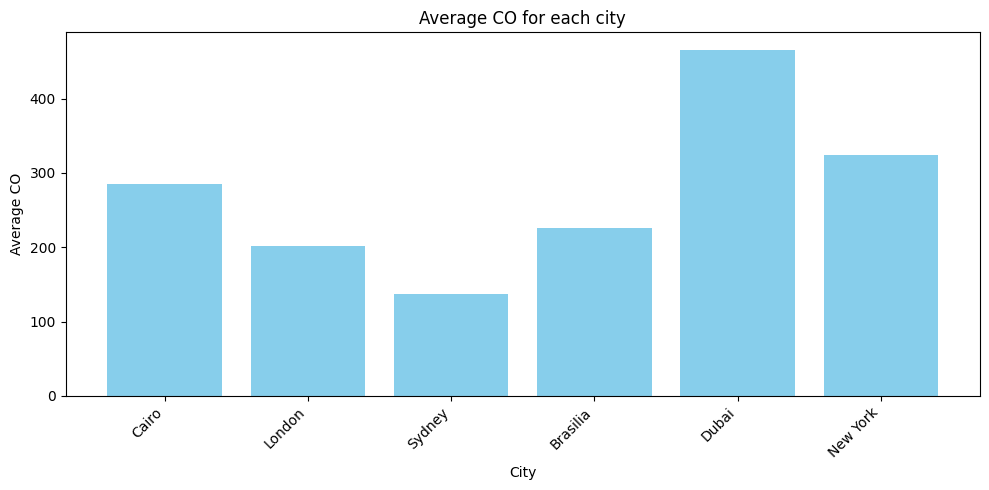

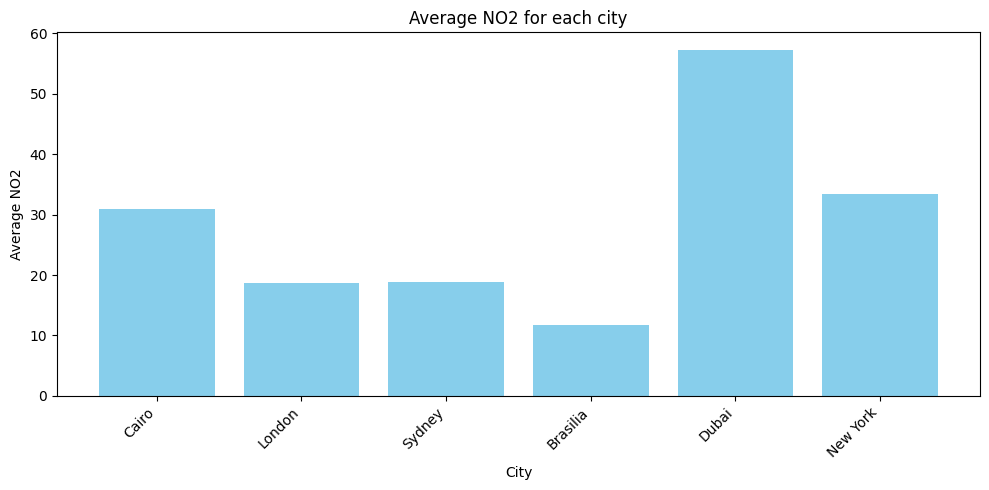

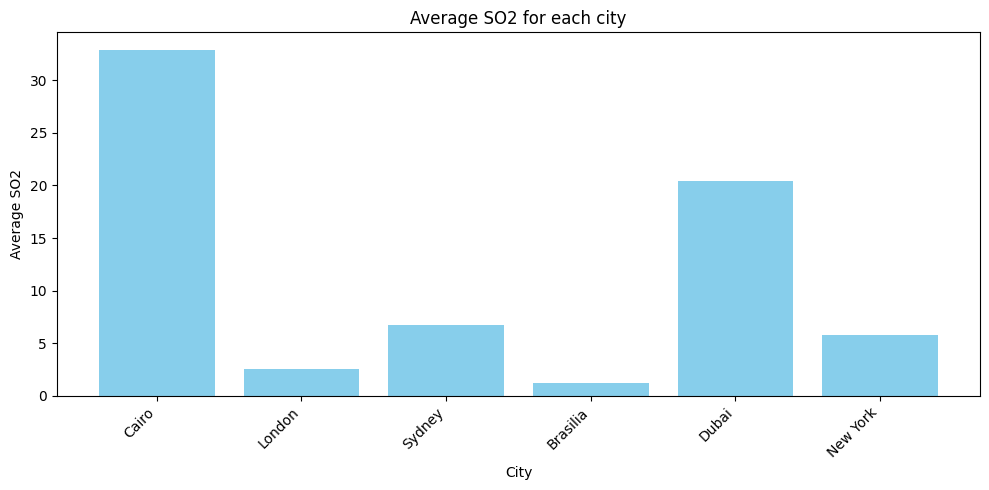

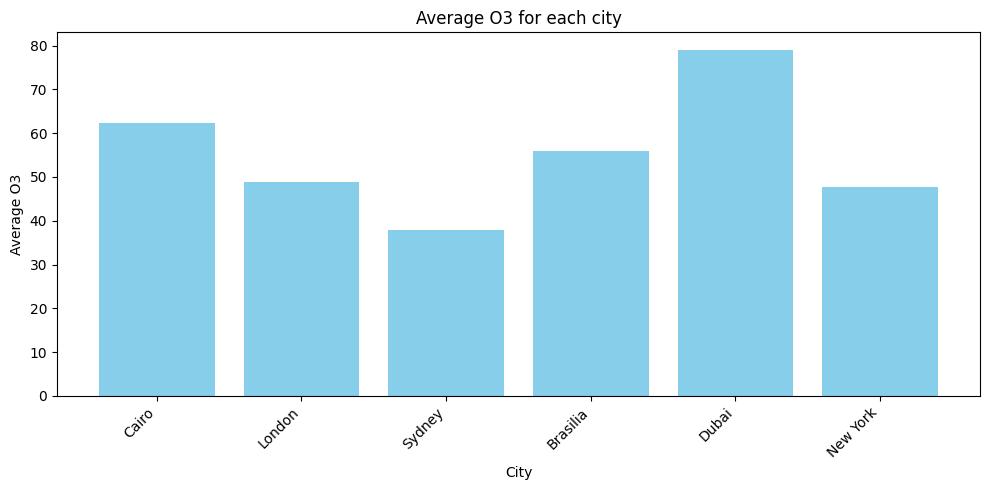

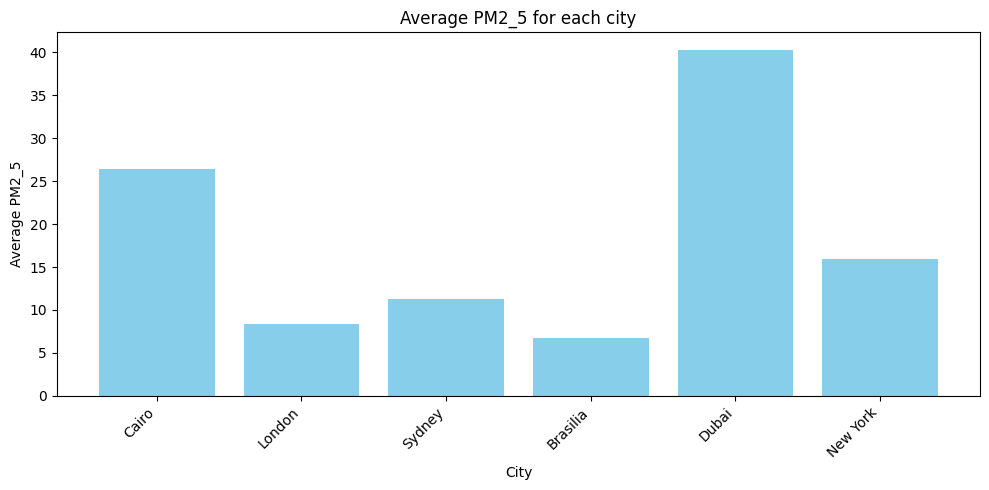

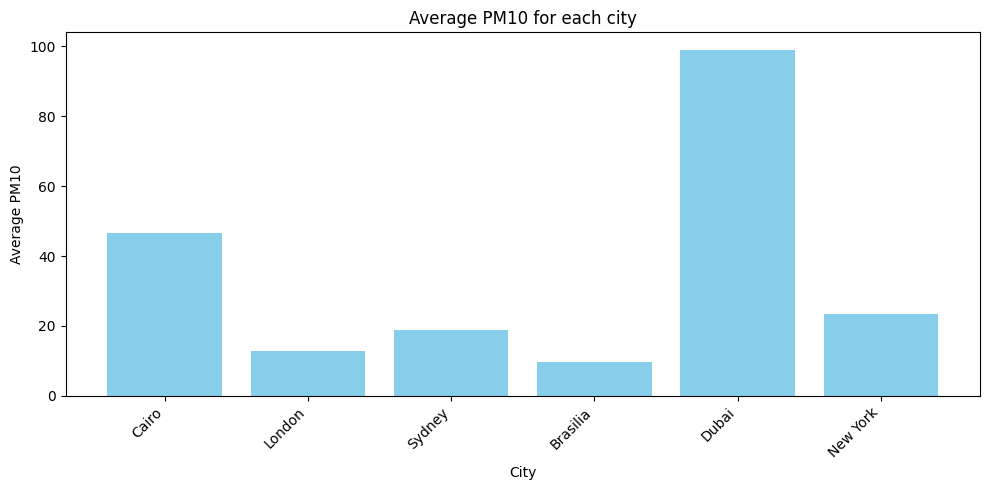

In [38]:
from pyspark.sql.functions import avg,col

city_avg = df.groupBy("City").agg(*[avg(col(c)).alias(f"avg_{c}") for c in columns_to_sum])
city_avg.orderBy("avg_CO", ascending=False).show(truncate=False)

# Converti in Pandas per visualizzazione
city_avg_pd = city_avg.toPandas()

# Plot per ogni inquinante
for el in columns_to_sum:
    plt.figure(figsize=(10, 5))
    plt.bar(city_avg_pd['City'], city_avg_pd[f'avg_{el}'], color='skyblue')
    plt.title(f'Average {el} for each city')
    plt.xlabel('City')
    plt.ylabel(f'Average {el}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:
from pyspark.sql.functions import avg

# Calcolo media per ogni inquinante

city_avg = df.groupBy("City").agg(*[avg(col(c)).alias(f"avg_{c}") for c in columns_to_sum])
city_avg.orderBy("avg_CO", ascending=False).show(truncate=False)

# Converti in Pandas per visualizzazione
city_avg_pd = city_avg.toPandas()

# Plot per ogni inquinante
for el in columns_to_sum:
    plt.figure(figsize=(10, 5))
    plt.bar(city_avg_pd['City'], city_avg_pd[f'average_{el}'], color='skyblue')
    plt.title(f'Media di {el} per città')
    plt.xlabel('Città')
    plt.ylabel(f'Media {el}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

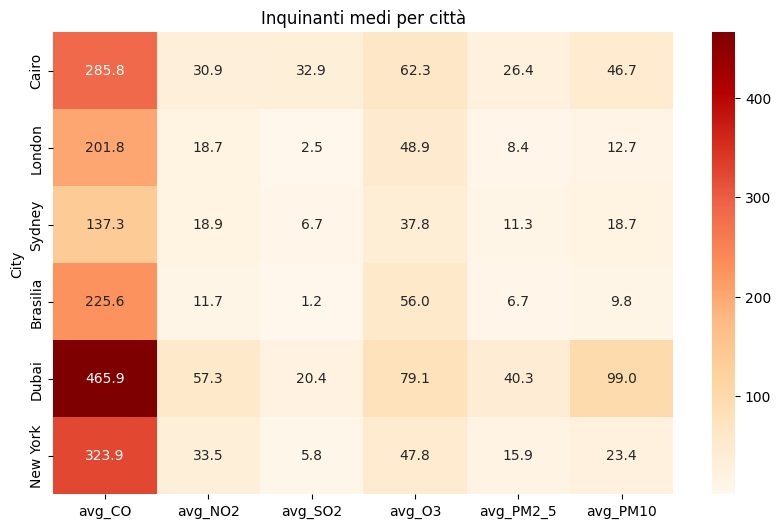

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che city_avg_pd sia un DataFrame con colonne 'City' e 'average_CO', ...
heat_df = city_avg_pd.set_index('City')[[f'avg_{c}' for c in columns_to_sum]]
plt.figure(figsize=(10, 6))
sns.heatmap(heat_df, cmap='OrRd', annot=True, fmt=".1f")
plt.title("Inquinanti medi per città")
plt.show()





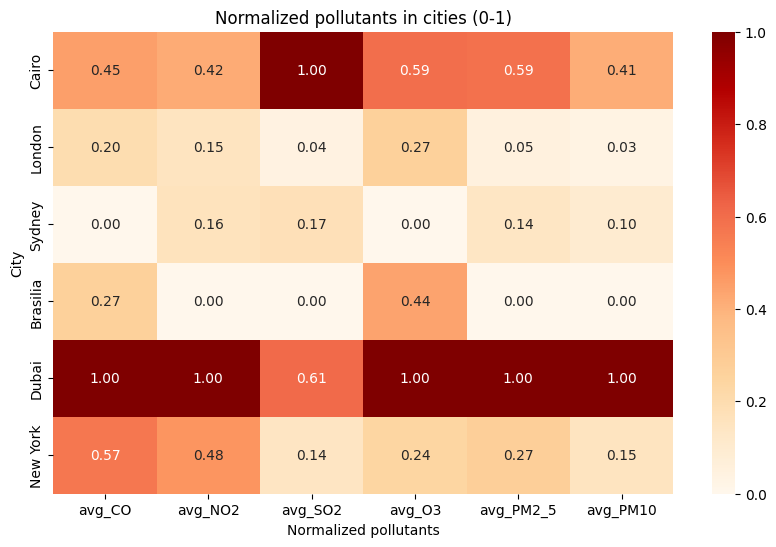

In [42]:
# Normalizza ogni colonna tra 0 e 1
normalized_df = heat_df.copy()

for col in normalized_df.columns:
    min_val = normalized_df[col].min()
    max_val = normalized_df[col].max()
    normalized_df[col] = (normalized_df[col] - min_val) / (max_val - min_val)
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_df, cmap='OrRd', annot=True, fmt=".2f")
plt.title("Normalized pollutants in cities (0-1)")
plt.ylabel("City")
plt.xlabel("Normalized pollutants")
plt.show()
